<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/MyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5913e000 @  0x7feea2d5a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [178]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
    

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

In [179]:
from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

#data set
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
print(num_train)

Files already downloaded and verified
Files already downloaded and verified
50000


In [180]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# index of num of train
indices = list(range(num_train))
#random the index
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
# divied into two part
train_idx, valid_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data,batch_size=batch_size,
    sampler = train_sampler,num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(
    train_data,batch_size=batch_size,
    sampler = valid_sampler,num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(
    test_data,batch_size=batch_size,num_workers = num_workers)

"""
# specify the image classes
classes = ['T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle Boot']
"""

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


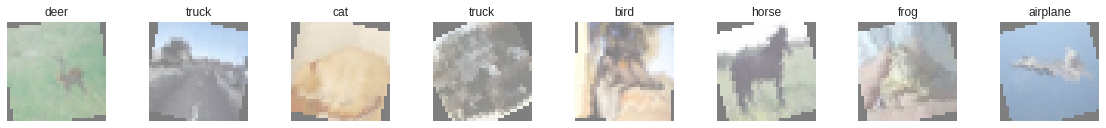

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    #ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))
    ax.set_title(classes[labels[idx]])

In [0]:
from torch import optim
from torch.optim import lr_scheduler
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
model.load_state_dict(torch.load("model_72.pt"))

In [184]:
# Train
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

train_loss_data, valid_loss_data = [],[] 

for epoch in range(n_epochs):
  train_loss = 0
  test_loss = 0
  accuracy = 0
  
  ###############
  # Train Model #
  ###############
  model.train()
  # step scheduler
  scheduler.step()
  
  for images, labels in train_loader:
    # move to cuda
    images, labels = images.to(device), labels.to(device)
    #zero gradient
    optimizer.zero_grad()
    # Forward pass
    output = model(images)
    #calculate loss
    loss = criterion(output,labels)
    # backward pass
    loss.backward()
    # perform a single optimization step (parameters update)
    optimizer.step()
    # update train loss
    train_loss += loss.item() * images.size(0)
  
  
  ######################
  # Validate the model #
  ######################
  model.eval()
  for images, labels in valid_loader:
    # move to cuda
    images, labels = images.to(device), labels.to(device)
    # Forward pass
    log_ps = model(images)
    #calculate loss
    loss = criterion(log_ps,labels)
    # update train loss
    valid_loss += loss.item() * images.size(0)
    # calculate accuracy
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  
  # Calculate the average loss in one epoch
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  # save the loss in an array
  train_loss_data.append(train_loss * 100)
  valid_loss_data.append(valid_loss * 100)
  
  # print the loss
  print("Epoch {}/{}".format(epoch+1,n_epochs),"\tTrain loss:{:.4f}".format(train_loss),
       "\t Valid Loss:{:.4f}".format(valid_loss),"\tAcceuracy:{:.2f}%".format(accuracy))
  
  # save the vodel
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = valid_loss

Epoch 1/20 	Train loss:1.5705 	 Valid Loss:0.3574 	Acceuracy:175.90%
Validation loss decreased (inf --> 0.3574).  Saving model ...
Epoch 2/20 	Train loss:1.4374 	 Valid Loss:0.3381 	Acceuracy:190.85%
Validation loss decreased (0.3574 --> 0.3381).  Saving model ...
Epoch 3/20 	Train loss:1.4218 	 Valid Loss:0.3574 	Acceuracy:172.75%
Epoch 4/20 	Train loss:1.4330 	 Valid Loss:0.3473 	Acceuracy:181.05%
Epoch 5/20 	Train loss:1.4399 	 Valid Loss:0.3526 	Acceuracy:181.45%
Epoch 6/20 	Train loss:1.2805 	 Valid Loss:0.3051 	Acceuracy:222.95%
Validation loss decreased (0.3381 --> 0.3051).  Saving model ...
Epoch 7/20 	Train loss:1.2182 	 Valid Loss:0.2950 	Acceuracy:234.90%
Validation loss decreased (0.3051 --> 0.2950).  Saving model ...
Epoch 8/20 	Train loss:1.1963 	 Valid Loss:0.2905 	Acceuracy:239.75%
Validation loss decreased (0.2950 --> 0.2905).  Saving model ...
Epoch 9/20 	Train loss:1.1724 	 Valid Loss:0.2830 	Acceuracy:246.55%
Validation loss decreased (0.2905 --> 0.2830).  Saving mo

In [0]:
model.load_state_dict(torch.load("model_cifar.pt"))

In [0]:
torch.save(model.state_dict(), 'model_72.pt')

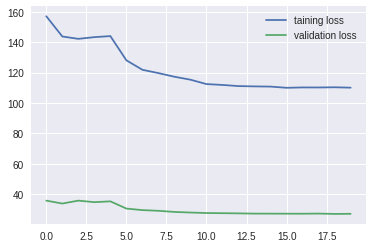

In [185]:
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)

In [186]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.331855

Test Accuracy of airplane: 56% (560/1000)
Test Accuracy of automobile: 66% (662/1000)
Test Accuracy of  bird: 36% (369/1000)
Test Accuracy of   cat: 40% (401/1000)
Test Accuracy of  deer: 41% (413/1000)
Test Accuracy of   dog: 39% (395/1000)
Test Accuracy of  frog: 57% (576/1000)
Test Accuracy of horse: 59% (590/1000)
Test Accuracy of  ship: 66% (660/1000)
Test Accuracy of truck: 56% (569/1000)

Test Accuracy (Overall): 51% (5195/10000)
